In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys

sys.path.append('/content/gdrive/My Drive/Colab Notebooks/ECE_Project')

In [0]:
import CNN_Lib
import CNN_BuildingBlock_Lib as BB
import RNN_BuildingBlock_Lib as RNN_BB
import CombinationModel as ComboCNN
import CombinationModel_RNN_CNN as RNN_CNN
import numpy as np 
import torch
from torch.autograd import Variable
import random
import pdb
import copy
import matplotlib.pyplot as plt


In [4]:
dir = '/content/gdrive/My Drive/Colab Notebooks/ECE_Project'
X_test = np.load(dir + '/X_test.npy')
y_test = np.load(dir + '/y_test.npy')
person_train_valid = np.load(dir + '/person_train_valid.npy')
X_train_valid = np.load(dir + '/X_train_valid.npy')
y_train_valid = np.load(dir + '/y_train_valid.npy')
person_test = np.load(dir + '/person_test.npy')
print ('Training/Valid data shape: {}' .format(X_train_valid.shape))
print ('Test data shape: {}' .format(X_test.shape))
print ('Training/Valid target shape: {}' .format(y_train_valid.shape))
print ('Test target shape: {}' .format(y_test.shape))
print ('Person train/valid shape: {}' .format(person_train_valid.shape))
print ('Person test shape: {}' .format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [0]:
#transform data into torch-readable data types
#2115 number of trials from 9 people
#four possible classes of outputs


Xtrain = torch.from_numpy(X_train_valid)
Ytrain = torch.from_numpy(y_train_valid)
Xtest = torch.from_numpy(X_test)
Ytest = torch.from_numpy(y_test)



In [0]:
def map_to_class(input_labels):
  mask1 = (input_labels == 769)*0
  mask2 = (input_labels == 770)*1
  mask3 = (input_labels == 771)*2
  mask4 = (input_labels == 772)*3

  return (mask1 + mask2 + mask3 + mask4)

In [0]:
def plot_val_train(validation_acc, train_acc, k, its):
  f = plt.figure(figsize=(15, 10))
  plt.title(f"Model Performance while Validating on K-Fold {k}")
  plt.plot(validation_acc, 'g-')
  plt.plot(train_acc, 'b-')
  plt.xticks(np.arange(0, its, step=50))  # Set label locations.
  return f


In [0]:
def smooth(x,window_size=11,window='hanning'):
  """
    Adapted from SciPy Cookbook
    Window can be: ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
  """
  smoothed = np.r_[x[window_size-1:0:-1], x, x[-2:-window_size-1:-1]]
  
  #moving average
  if window == 'flat':
      w = np.ones(window_len,'d')
  else:
      w = eval('np.' + window + '(window_size)')

  smoothed = np.convolve(w/w.sum(), smoothed, mode='valid')
  if len(x) < len(smoothed):
    dif = abs(len(x) - len(smoothed))//2
    smoothed = smoothed[dif:len(smoothed)-dif]
  return smoothed

In [0]:
def augment_data(data_set, window_size, window):
  out = np.zeros_like(data_set)
  out = torch.from_numpy(out)
  for i in range(data_set.shape[0]):
    for j in range(data_set.shape[1]):
      out[i,j,:] = torch.from_numpy(smooth(data_set[i,j,:], window_size, window))
  return out

In [10]:
######### AUGMENT DATASET
Augmented = augment_data(X_train_valid, 11,'hanning')
idx = np.arange(X_train_valid.shape[2]//2)
np.random.shuffle(idx)

OutX = torch.cat((Xtrain, Augmented[idx]),0)
OutY = torch.cat((Ytrain, Ytrain[idx]),0)
print(OutX.size())

Xtrain = OutX
Ytrain = OutY

torch.Size([2615, 22, 1000])


In [11]:
########## INITIALIZE RNN-CNN COMBINATION MODEL ########## 

Trials, InputDim, SeqDim = X_train_valid.shape
num_features = InputDim
Tests = y_test.shape


#-----RNN tweak here----#
hidden_dim = 64 #above 150 and we get low training accuracy
num_layers = 1 #increasing this makes training take MUCH longer, similar validation and lower training accuracy
nonlinearity = 'tanh'
initialization = 'xavierNorm'


#-----CNN tweak here----#
num_filters = [64, 64, 64] #64, 32, 32 up to 70% V, and 64, 64, 32 plateud at ~61-63% after Epoch 1 then increased to 67% | 72 max
batch_size = 30   #smaller batch sizes (less than 50) offer a regularization effect | must be less than 423 bc we are using kfold validation of 5
num_classes = 4
L2 = 0.22 #higher than 0.25 and the validation doesnt reach 70
cnnfilter_stride = [2, 1, 1] #big filter stride makes training to acceptable validation take longer. 
cnnfilter_size = [10, 3, 3] #smaller filter size appears to make higher validation from the beginning. lower than 2 is pretty bad?
cnn_padding = [1, 1, 1]
use_bias = [False, True, False]
use_maxpool = [True, True, True] #not using it makes the model overfit
pool_size = [5, 3, 2]
pool_stride = [2, 1, 1]
use_batchnorm = [True, True, True]
eps = [1e-4, 1e-4, 1e-4]
momentum = [0.3, 0.8, 0.5]
affine = [False, False, False]
dropout = [0.13, 0.21, 0.1, 0.55]

#-----OPTIM tweak here----#
learning_rate = 0.0001 #0 we trained faster with this vs 0.0001 

combo_model = RNN_CNN.CombinationModel_RNN_CNN(InputDim, SeqDim, hidden_dim, num_layers, nonlinearity, initialization, num_filters, cnnfilter_size, cnnfilter_stride, cnn_padding, use_bias, num_classes, use_maxpool, pool_size, pool_stride, use_batchnorm, eps, momentum, affine, dropout)
combo_model.to('cuda:0') #--- activate the GPU


DONE INITIALIZING


CombinationModel_RNN_CNN(
  (RNN_Block): EEG_RNN_BuildingBlock(
    (RNN): RNN(22, 64, batch_first=True)
  )
  (CNN_Block1): EEG_CNN_BuildingBlock(
    (CNN): Conv1d(64, 128, kernel_size=(5,), stride=(2,), padding=(1,), bias=False)
    (RELU): ReLU()
    (BatchNorm): BatchNorm1d(128, eps=0.0001, momentum=0.3, affine=False, track_running_stats=True)
    (DropOut): Dropout(p=0.13, inplace=False)
    (MaxPool): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (CNN_Block2): EEG_CNN_BuildingBlock(
    (CNN): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (RELU): ReLU()
    (BatchNorm): BatchNorm1d(64, eps=0.0001, momentum=0.8, affine=False, track_running_stats=True)
    (DropOut): Dropout(p=0.21, inplace=False)
    (MaxPool): MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (CNN_Block3): EEG_CNN(
    (CNN): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (RELU): ReLU()
    (BatchNor

In [0]:
########## CHOOSE LOSS  ###########
loss = torch.nn.CrossEntropyLoss()

######### CHOOSE OPTIMIZER ########
optim = torch.optim.Adam(combo_model.parameters(), lr=learning_rate, weight_decay=L2)
#optim = torch.optim.Adadelta(combo_model.parameters()) << does worse than Adam, we overfit so much 

...... Training for Epoch 0 ......
DONE INITIALIZING
______ Training for k-folds [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] ______


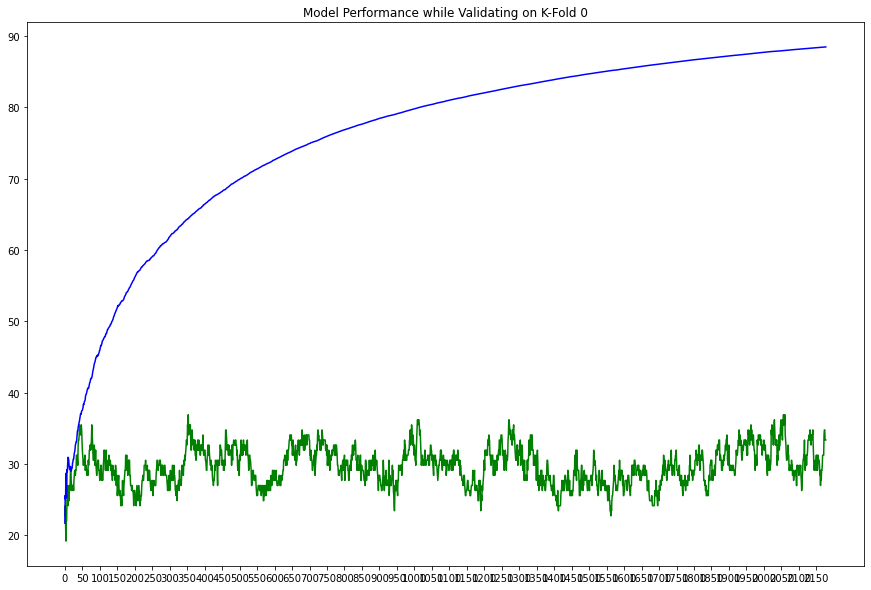

DONE INITIALIZING
______ Training for k-folds [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14] ______


KeyboardInterrupt: ignored

In [15]:
######## TRAIN IT ######## .... got up to 58% but huge range. from 30 was the low.
#------ With Early Stopping AND K-Fold Validation -----#
epochs = 1
kfolds = 15
iterations = 2200
iter_ = 0
validate_fold = 0
SEED = 2000

stop_now = False
loss_store = [[] for i in range(kfolds)]
validation_store = [[] for i in range(kfolds)]
training_store = [[] for i in range(kfolds)]
network_store = [[] for i in range(kfolds)]
model_store = []

#k fold validation here
np.random.seed(random.randint(1,SEED))
fold_size = int(Trials/kfolds)
idx = np.arange(Trials)
np.random.shuffle(idx)
Xtrain_Shuffled = Xtrain[idx]
Ytrain_Shuffled = Ytrain[idx]

FoldsX = Xtrain_Shuffled.split(fold_size)
FoldsY = Ytrain_Shuffled.split(fold_size)

for epoch in range(epochs):
  if stop_now:
    break

  print(f"...... Training for Epoch {epoch} ......")
  for k in range(kfolds): 
    train_correct = 0
    train_total = 0

    #total = 0
    #correct = 0

    #create training folds by excluding validate fold
    train_folds = list(range(kfolds))
    del train_folds[validate_fold]
    train_folds = np.array(train_folds)
    TrainX = torch.cat([FoldsX[f] for f in train_folds]) 
    TrainY = torch.cat([FoldsY[f] for f in train_folds])

    #create validate fold
    ValidateX = FoldsX[validate_fold]
    ValidateY = FoldsY[validate_fold]

    #initialize the network within the kfold loop
    combo_model = RNN_CNN.CombinationModel_RNN_CNN(InputDim, SeqDim, hidden_dim, num_layers, 
                                                   nonlinearity, initialization, num_filters, 
                                                   cnnfilter_size, cnnfilter_stride, cnn_padding, 
                                                   use_bias, num_classes, use_maxpool, pool_size, 
                                                   pool_stride, use_batchnorm, eps, momentum, affine, dropout)

    combo_model.to('cuda:0') #--- activate the GPU
    loss = torch.nn.CrossEntropyLoss()
    optim = torch.optim.Adam(combo_model.parameters(), lr=learning_rate, weight_decay=L2) 

    print(f"______ Training for k-folds {train_folds} ______")
    for i in range(iterations):
      #do the batches
      idx = np.arange(TrainX.size(0))
      np.random.shuffle(idx)
      idx = idx[0:batch_size]

      #process the input data
      xtrain = TrainX[idx].view(batch_size, SeqDim, InputDim)
      xtrain = xtrain.to('cuda:0').requires_grad_()
      ytrain = TrainY[idx]

      #put the model in training mode
      combo_model.train(True)

      #forward pass
      optim.zero_grad()
      outFC = combo_model.forward(xtrain.float())
  
      #map to classes
      classes = map_to_class(ytrain.long())
      classes = classes.to('cuda:0')

      #backward pass (gradient calculation)
      probs = loss(outFC, classes)
      probs.backward()

      #update weights
      optim.step()

      #update iter counter
      iter_+=1

      #calculate training accuracy
      #train_pred = F.softmax(outFC, 1)
      values, predicted = torch.max(outFC, 1)
      train_correct += (1*(predicted == classes)).sum()
      train_total += float(classes.size(0))

      if i % 100:
        #print(f"______ Validating for k-fold {k} ______")
        combo_model.eval()
        
        #process the input data
        idx = np.random.randint(0, Tests, size=batch_size)
        xvalid = ValidateX.view(-1, SeqDim, InputDim)
        xvalid = xvalid.to('cuda:0')
        yvalid = ValidateY

        #forward prop
        predict = combo_model(xvalid.float())
        
        #predict
        #pred = F.softmax(predict, 1)
        values, predicted_classes = torch.max(predict, 1)
        expected_classes = map_to_class(yvalid)
        correct = (1*(predicted_classes == expected_classes.to('cuda:0'))).sum()
        total =float(predicted_classes.size(0))

        #evaluate
        validation_accuracy = 100*(correct/total)
        training_accuracy = 100*(train_correct/train_total)

        #print(f"correct: {correct}, total: {total}")
        #print(f"prediction: {predicted_classes}\nexpected_classes: {expected_classes}")
        #print(f"Iteration: {iter_}, Loss: {probs.item()}, Validation Accuracy: {validation_accuracy}%, Training Accuracy: {training_accuracy}%\n")  

        #store info for graphing later
        validation_store[k].append(validation_accuracy.item())
        loss_store[k].append(probs.item())
        training_store[k].append(training_accuracy.item())
        
        #--- Early stopping criterion here --- #
        if validation_accuracy > 80.0:
          #store
          print("Early Stopping!")
          stop_now = True
          break
    
    #iterate the validate fold
    validate_fold +=1

    #store the model
    model_store.append(copy.deepcopy(combo_model))

    #plot things
    plot = plot_val_train(validation_store[k], training_store[k], k, iterations)    
    plt.show(plot)

In [0]:
#Find Best Model and Test It
best_ind = 0
best_model = None
  
best_model = model_store[best_ind]

print(f"______ Evaluating On Test Data ______")
best_model.eval()

total = 0
correct = 0

#process the input data
xtest = Xtest.view(-1, SeqDim, InputDim)
xtest = xtest.to('cuda:0')
ytest = Ytest

#forward prop
predict = best_model(xtest.float())

#predict
values, predicted_classes = torch.max(predict, 1)
expected_classes = map_to_class(ytest)        
correct += (1*(predicted_classes == expected_classes.to('cuda:0'))).sum()
total +=float(predicted_classes.size(0))

#evaluate
test_accuracy = 100*(correct/total)

print(f"correct: {correct}, total: {total}")
print(f"Testing Accuracy: {test_accuracy}%")  
print(f"Vaidation Accuracy: {max(validation_store[best_ind])}")
print(f"Training Accuracy: {max(training_store[best_ind])}")


______ Evaluating On Test Data ______
correct: 150, total: 443.0
Testing Accuracy: 33.86004638671875%
Vaidation Accuracy: 39.71630859375
Training Accuracy: 88.14242553710938


/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
